# Introduction

In this notebook, we perform exploration on the 2021-2023 NSDUH data with the goals of: 

1) Learning more about the demographic characteristics of young adults aged 18-25 
2) Learning more about the substance use and mental health patterns among young adults
3) Examining the associations between our confounders and mental health
4) Examining initial associations between illicit substance use and mental health

To accomplish goal 1, we create bar plots that reveal frequencies of demographics among Young adults such as income, household composition, and education. 

To accomplish goal 2, we create bar plots to examine substance use and mental health patterns.

To accomplish goal 3, we create comparative tables (followed up with chi-squared tests and 2 sample t-tests in RStudio).

To accomplish goal 4, we do a combination of bar plots with variability measures and inferential statistics to capture initial associations between illicit substance use and mental health outcomes.

By learning more about the demographic characteristics of Young Adults, we gain an understanding of our sample.

By learning more about substance use and mental health patterns among young adults, we can gain an initial understanding on why young adults is an important population to be studied in health-related research: their tendency to experience more substance use and mental health issues (as outlined in the 2023 NSDUH national report). 

By examining the associations between our covariates and mental health, we gain an important understanding of confounders that influence the relationship between illicit substance use and mental health, which will be accounted for in our logistic regression analysis.

By examining initial associations between illicit substance use and mental health, we can gain an initial understanding on how illicit substance use is associated with mental health outcomes among young adults, motivating us to dive deeper into areas where there is a clear association shown between illicit substance use and mental health.

In [86]:
#Import modules
import os #file path
import pandas as pd #Access, modify, and manipulate data
import matplotlib.pyplot as plt #Data visualization
import seaborn as sns #Data visualization 
import numpy as np #Numerical computation
from samplics.categorical import Tabulation #Survey design
from samplics.estimation import TaylorEstimator #Survey design
from samplics.utils.types import PopParam #Survey design
#Base path to GitHub repository
path="C:/Users/John Platt/OneDrive/DA301Project/John-Platt-DA-401-Project"
#Directory where the project data is
datadir="data"

In [87]:
#Read in the cleaned 2023 NSDUH dataset
nsduh_2123 = pd.read_csv(os.path.join(path, datadir, "NSDUH_2021_2023.csv"))

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\3537155704.py:2: DtypeWarning: Columns (20,26) have mixed types. Specify dtype option on import or set low_memory=False.
  nsduh_2123 = pd.read_csv(os.path.join(path, datadir, "NSDUH_2021_2023.csv"))


In [88]:
#Delete first column of the data that has the row numbers (starts at 1)
nsduh_2123.drop('Unnamed: 0', axis=1, inplace=True) 
#Print out the dataset
nsduh_2123

,ANALWT2_C3,YEAR,VESTR_C,VEREP,IRSEX,CATAGE,NEWRACE2,EDUHIGHCAT,IRWRKSTAT18,IRHHSIZ2,...,IRHALLUCYFQ,IRALCBNG30D,SUTINPPY,IRDSTNRV12,IRDSTEFF12,IRIMPCONCN,IRSUICTHNK,IRAMDEYR,MHTINPPY,AMISUD5ANYO
0,244.294926,2021,40047,1,Female,3,Nonhisp White,Some coll/Assoc Dg,Other (incl. not in labor force),Two people in household,...,0,0,NaN,LEGITIMATE SKIP,LEGITIMATE SKIP,No difficulty,No,No,NaN,Neither SUD or AMI
1,3903.338714,2021,40037,2,Male,4,Nonhisp White,College graduate,Other (incl. not in labor force),Two people in household,...,0,0,NaN,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,NaN,Neither SUD or AMI
2,155.644805,2021,40037,2,Female,2,Nonhisp White,College graduate,Employed full time,Two people in household,...,0,0,NaN,All of the time,Some of the time,Mild difficultly,No,No,NaN,"AMI only, no SUD"
3,3690.146525,2021,40045,2,Male,4,Nonhisp White,Less high school,Other (incl. not in labor force),Three people in household,...,0,0,NaN,LEGITIMATE SKIP,LEGITIMATE SKIP,Moderate difficulty,No,No,NaN,SUD and AMI
4,72.793256,2021,40006,1,Male,2,Hispanic,High school grad,Other (incl. not in labor force),One person in household,...,0,0,NaN,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,NaN,Neither SUD or AMI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173803,139.210040,2023,40018,2,Female,4,Hispanic,Less high school,Employed part time,Four people in household,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
173804,2541.905978,2023,40017,1,Female,4,Nonhisp White,Some coll/Assoc Dg,Other (incl. not in labor force),Four people in household,...,0,0,No,Most of the time,None of the time,No difficulty,No,No,No,Neither SUD or AMI
173805,7852.027969,2023,40042,1,Female,4,Nonhisp White,College graduate,Employed full time,One person in household,...,3,5,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
173806,1731.294208,2023,40040,2,Male,4,NonHisp Asian,College graduate,Other (incl. not in labor force),Two people in household,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,No difficulty,No,No,No,Neither SUD or AMI


In [89]:
def rel_frequencies(df,xvar,na_rm=True):
    '''
    Compute weighted frequencies (including accounting for survey design)
    across demographics 

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with frequencies and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new column based on where there are Young Adults in the cleaned dataset
    df["subpop_xvar"]=df[xvar].where(df["CATAGE"] == 2, np.nan)
    #Tabulation function calculates and tabulates summary statistics of a categorical variable given
    #survey weights and survey design measures
    #We account for the subpopulation (Young Adults) WHEN we do the tabulation 
    #Don't filter data down to Young Adults before doing the tabulation as 
    #that would bias the SE/variance estimates towards that specific subgroup rather than the total population
    #Tabulation with full dataset, but subpopulation defined
    tab = Tabulation(PopParam.prop)  
    tab.tabulate(
        #Column we want to tabulate relative frequencies based on 
        vars=df[["subpop_xvar"]],
        #2023 NSDUH sample weight
        samp_weight=df["ANALWT2_C3"],
        #Variance stratum
        stratum=df["VESTR_C"],
        #Variance primary sampling unit
        psu=df["VEREP"],
        remove_nan=na_rm
    )
    #Convert the weighted frequency estimates to a dataframe
    df=tab.to_dataframe()
    #Sort the frequency dataframe by frequencies in descending order
    df.sort_values(by=PopParam.prop,ascending=False,inplace=True)
    return df

In [90]:
def rel_freq_barplot(df,xvar,xlabel,xaxisrotation,title):
    '''
    Given a dataframe, creates barplot for relative frequencies of one variable
    
    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The variable that will be the x-axis of our barplot (variable that we will show proportions of)
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The frequency table
    '''   
    #Create table with weighted relative frequency estimates 
    df=rel_frequencies(df,xvar,na_rm=True)
    #Create percentage column
    df['Percentage']=df[PopParam.prop]*100
    #Create column that has the lower bound of 95% CI expressed as a percentage
    df['Lower_ci_percentage']=df["lower_ci"]*100
    #Create column that has the upper bound of 95% CI expressed as a percentage
    df['Upper_ci_percentage']=df["upper_ci"]*100
    #Create new column that calculates the lower error based on the percentage subtracted to the Lower_ci_percentage
    df['lower_error']=df["Percentage"]-df['Lower_ci_percentage']
    #Create new column that calculates the upper error based on the percentage subtracted to the Upper_ci_percentage
    df['upper_error']=df['Upper_ci_percentage']-df["Percentage"]
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['category'],df['Percentage'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Proportion (%)")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return frequency table
    return df

In [91]:
def frequencies(df,xvar,na_rm=True):
    '''
    Compute weighted counts (including accounting for survey design)
    across demographics 

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The demographic variable that will be generate counts from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with frequencies and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new column based on where there are Young Adults in the cleaned dataset
    df["subpop_xvar"]=df[xvar].where(df["CATAGE"] == 2, np.nan)
    #Do tabulation to estimate counts of demographoic variable
    tab = Tabulation(PopParam.count)  
    tab.tabulate(
        #Column we want to tabulate relative frequencies based on 
        vars=df[["subpop_xvar"]],
        #2023 NSDUH sample weight
        samp_weight=df["ANALWT2_C3"],
        #Variance stratum
        stratum=df["VESTR_C"],
        #Variance primary sampling unit
        psu=df["VEREP"],
        remove_nan=na_rm
    )
    totals=tab.to_dataframe()
    #Extract unweighted counts of subpop_xvar
    category_uw_counts=df['subpop_xvar'].value_counts()
    return totals, category_uw_counts

In [92]:
def avg_tbl(df,xvar,na_rm=True):
    '''
    Compute weighted mean (including accounting for survey design)
    across substance use measures

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with substance use averages (for Young Adults and all other populations) and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new domain variable based on where there are Young Adults in the cleaned dataset
    #This will be used when accounting for subgroup analysis in the taylor estimation
    domain=(df["CATAGE"] == 2).astype(int)
    #Taylor estimator for mean substance use frequency
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar], #Substance use variable calculating the mean frequency on
        samp_weight=df['ANALWT2_C3'], #Sample weight
        stratum=df['VESTR_C'], #Variance stratum
        psu=df['VEREP'], #Primary sampling unit
        domain=domain, #pass subgroup vector
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out['_domain'] = out['_domain'].replace({1: 'Young Adults', 0: 'All Other Populations'})
    #Sort the dataframe in descending order by the mean estimates
    out.sort_values(by='_estimate',ascending=False,inplace=True)
    #Return dataframe with mean (accounts for complex survey design)
    return out

In [93]:
def mean_comp(df,xvar,xlabel,xaxisrotation,title):
    '''
    Create bar plots with error bars that compare substance use averages between Young Adults aged 18-25 and
    all other populations

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The variable that will be the x-axis of our barplot (variable that we will show averages of)
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The averages table
    '''    
    df=df.copy()
    #Obtain averages table
    df=avg_tbl(df,xvar,na_rm=True)
    #Create new column that calculates the lower error based on the average subtracted to the _lci
    df['lower_error']=df['_estimate']-df['_lci']
    #Create new column that calculates the upper error based on the average subtracted to the _uci
    df['upper_error']=df['_uci']-df['_estimate']
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['_domain'],df['_estimate'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Average")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return averages table
    return df
    

In [94]:
def avg_tbl2(df,xvar,yvar,na_rm=True):
    '''
    Compute weighted mean (including accounting for survey design)
    across substance use measures by mental health measures

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    yvar - string - The mental health variable we are comparing substance use measures across
    na_rm - boolean - Whether or not we will eliminate missing values
    Return:
    Table with substance use averages (for Young Adults and all other populations) and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create domain series for Young Adults who have experienced the specified mental health issue (yvar)
    domain_yes = ((df["CATAGE"]==2) & (df[yvar]=='Yes')).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 1 (Young Adults 
    #who experienced the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_yes,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out1 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out1['_domain'] = out1['_domain'].replace({1: 'Yes', 0: 'All Other Populations'})
    #Create domain series for Young Adults who have NOT experienced the specified mental health issue (yvar)
    domain_no = ((df["CATAGE"]==2) & (df[yvar]=='No')).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 2 (multiracial young 
    #adults who did not experience the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_no,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out2 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out2['_domain'] = out2['_domain'].replace({1: 'No', 0: 'All Other Populations'})
    #Combine the two dataframes, taking the row of each dataframe where _domain=Group 1 or _domain=Group 2
    group_comp=pd.concat([out1.loc[out1['_domain']=='Yes',:],out2.loc[out2['_domain']=='No',:]])
    #Sort the combined dataframe
    group_comp.sort_values(by='_estimate',ascending=False,inplace=True)
    #Return dataframe with mean (accounts for complex survey design) illicit substance use for each group
    return group_comp

In [95]:
def avg_tbl3(df,xvar,yvar,na_rm=True):
    '''
    Compute weighted mean (including accounting for survey design)
    across potential substance use confounders by suicidal thoughts 

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    yvar - string - The mental health variable we are comparing substance use measures across
    na_rm - boolean - Whether or not we will eliminate missing values
    Return:
    Table with substance use averages (for Young Adults and all other populations) and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Recode suicidal ideation variable
    df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
    #Create domain series for Young Adults who have experienced the specified mental health issue (yvar)
    domain_yes = ((df["CATAGE"]==2) & (df[yvar]==1)).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 1 (Young Adults 
    #who experienced the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_yes,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out1 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out1['_domain'] = out1['_domain'].replace({1: 'Yes', 0: 'All Other Populations'})
    #Create domain series for Young Adults who have NOT experienced the specified mental health issue (yvar)
    domain_no = ((df["CATAGE"]==2) & (df[yvar]==0)).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 2 (multiracial young 
    #adults who did not experience the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_no,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out2 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out2['_domain'] = out2['_domain'].replace({1: 'No', 0: 'All Other Populations'})
    #Combine the two dataframes, taking the row of each dataframe where _domain=Group 1 or _domain=Group 2
    group_comp=pd.concat([out1.loc[out1['_domain']=='Yes',:],out2.loc[out2['_domain']=='No',:]])
    #Sort the combined dataframe
    group_comp.sort_values(by='_estimate',ascending=False,inplace=True)
    #Return dataframe with mean (accounts for complex survey design) substance use for each group
    return group_comp

In [96]:
def mean_comp2(df,xvar,yvar,xlabel,xaxisrotation,title):
    '''
    Create bar plots with error bars that compare substance use averages between Young Adults aged 18-25 and
    all other populations

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The illicit substance use variable that will be the y-axis of our barplot (variable that we will show averages of)
    yvar - string - The mental health variable that will be on the x-axis of our barplot
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The averages table 
    '''    
    df=df.copy()
    #Obtain averages table
    df=avg_tbl2(df,xvar,yvar,na_rm=True)
    #Create new column that calculates the lower error based on the average subtracted to the _lci
    df['lower_error']=df['_estimate']-df['_lci']
    #Create new column that calculates the upper error based on the average subtracted to the _uci
    df['upper_error']=df['_uci']-df['_estimate']
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['_domain'],df['_estimate'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Average")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return averages table
    return df

# Understanding Our Sample

In this section, we accomplish goal 1 outlined in the introduction. 

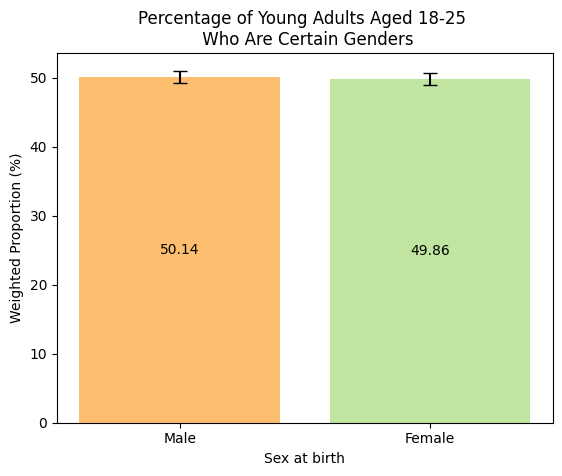

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Male,0.501383,0.004511,0.492323,0.510443,50.138317,49.232263,51.044281,0.906054,0.905964
0,subpop_xvar,Female,0.498617,0.004511,0.489557,0.507677,49.861683,48.955719,50.767737,0.905964,0.906054


In [97]:
#Examine gender frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRSEX','Sex at birth',0,"Percentage of Young Adults Aged 18-25 \n Who Are Certain Genders")

In [98]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRSEX',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar   Female    1.699916e+07  342645.607431  1.631093e+07   
 1  subpop_xvar     Male    1.709347e+07  343086.504679  1.640436e+07   
 
        upper_ci  
 0  1.768738e+07  
 1  1.778258e+07  ,
 subpop_xvar
 Female    22447
 Male      19426
 Name: count, dtype: int64)

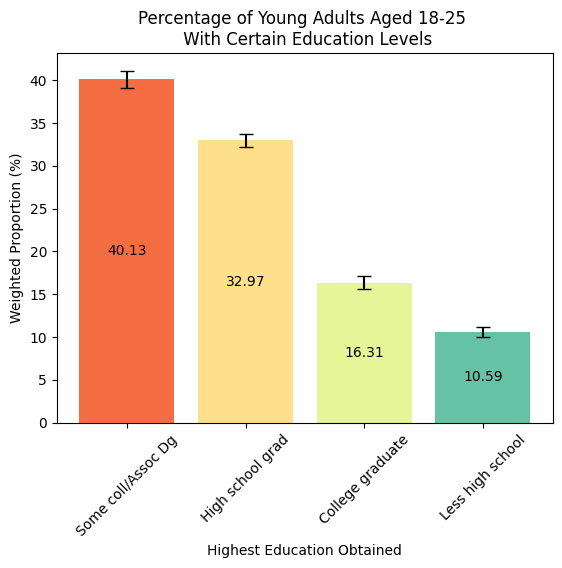

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
3,subpop_xvar,Some coll/Assoc Dg,0.401302,0.004900,0.391502,0.411182,40.130205,39.150198,41.118166,0.980007,0.987962
1,subpop_xvar,High school grad,0.329672,0.003566,0.322550,0.336874,32.967214,32.254958,33.687377,0.712256,0.720163
0,subpop_xvar,College graduate,0.163117,0.003790,0.155647,0.170873,16.311694,15.564722,17.087260,0.746972,0.775566
2,subpop_xvar,Less high school,0.105909,0.002768,0.100476,0.111599,10.590887,10.047638,11.159864,0.543249,0.568977


In [99]:
#Examine education frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'EDUHIGHCAT','Highest Education Obtained',45,"Percentage of Young Adults Aged 18-25 \n With Certain Education Levels")

In [100]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'EDUHIGHCAT',na_rm=True)

(      variable            category  PopParam.count       stderror  \
 0  subpop_xvar    College graduate    5.561085e+06  182674.271223   
 1  subpop_xvar    High school grad    1.123939e+07  215377.800150   
 2  subpop_xvar    Less high school    3.610711e+06  107418.480356   
 3  subpop_xvar  Some coll/Assoc Dg    1.368144e+07  298590.482598   
 
        lower_ci      upper_ci  
 0  5.194173e+06  5.927997e+06  
 1  1.080679e+07  1.167199e+07  
 2  3.394955e+06  3.826468e+06  
 3  1.308170e+07  1.428118e+07  ,
 subpop_xvar
 High school grad      14567
 Some coll/Assoc Dg    14475
 College graduate       7319
 Less high school       5512
 Name: count, dtype: int64)

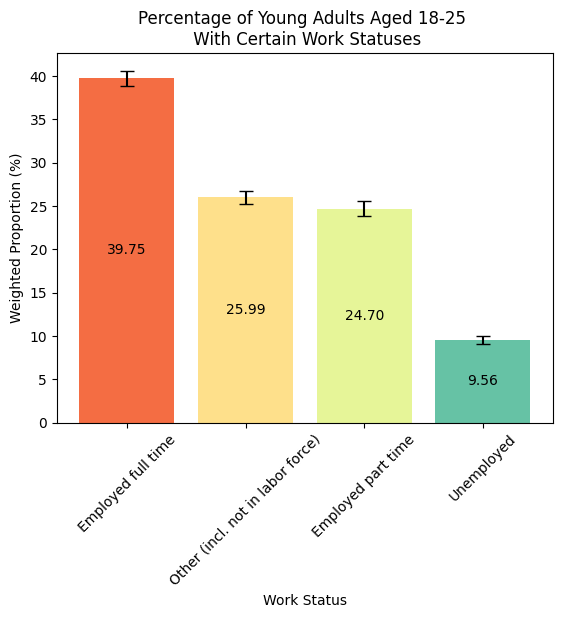

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,Employed full time,0.397476,0.004278,0.388916,0.406100,39.747625,38.891611,40.609958,0.856013,0.862334
2,subpop_xvar,Other (incl. not in labor force),0.259901,0.003774,0.252392,0.267553,25.990059,25.239173,26.755288,0.750885,0.765230
1,subpop_xvar,Employed part time,0.247016,0.004172,0.238731,0.255491,24.701570,23.873133,25.549106,0.828437,0.847536
3,subpop_xvar,Unemployed,0.095607,0.002349,0.090991,0.100432,9.560747,9.099148,10.043175,0.461599,0.482429


In [101]:
#Examine work status among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRWRKSTAT18','Work Status',45,"Percentage of Young Adults Aged 18-25 \n With Certain Work Statuses")

In [102]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRWRKSTAT18',na_rm=True)

(      variable                          category  PopParam.count  \
 0  subpop_xvar                Employed full time    1.355101e+07   
 1  subpop_xvar                Employed part time    8.421413e+06   
 2  subpop_xvar  Other (incl. not in labor force)    8.860693e+06   
 3  subpop_xvar                        Unemployed    3.259510e+06   
 
         stderror      lower_ci      upper_ci  
 0  314677.179354  1.291896e+07  1.418306e+07  
 1  190055.789556  8.039675e+06  8.803152e+06  
 2  198580.508419  8.461832e+06  9.259554e+06  
 3   95185.764998  3.068323e+06  3.450696e+06  ,
 subpop_xvar
 Employed full time                  16843
 Other (incl. not in labor force)    11100
 Employed part time                   9892
 Unemployed                           4038
 Name: count, dtype: int64)

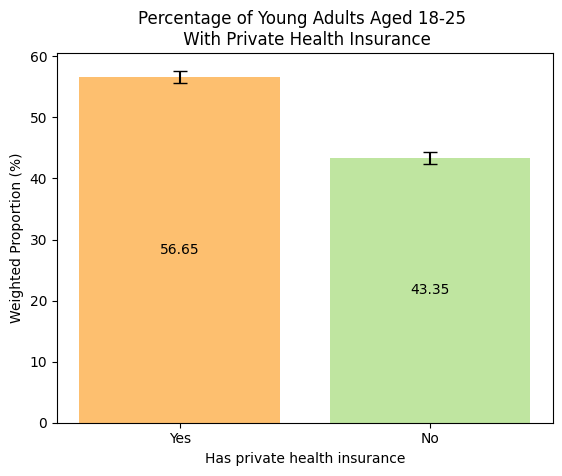

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Yes,0.566519,0.00496,0.556531,0.576454,56.651918,55.653056,57.645404,0.998862,0.993486
0,subpop_xvar,No,0.433481,0.00496,0.423546,0.443469,43.348082,42.354596,44.346944,0.993486,0.998862


In [103]:
#Examine private health insurance frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRPRVHLT','Has private health insurance',0,"Percentage of Young Adults Aged 18-25 \n With Private Health Insurance")

In [104]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRPRVHLT',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar       No    1.477850e+07  283372.607339  1.420933e+07   
 1  subpop_xvar      Yes    1.931413e+07  416916.898260  1.847672e+07   
 
        upper_ci  
 0  1.534767e+07  
 1  2.015153e+07  ,
 subpop_xvar
 Yes    22878
 No     18995
 Name: count, dtype: int64)

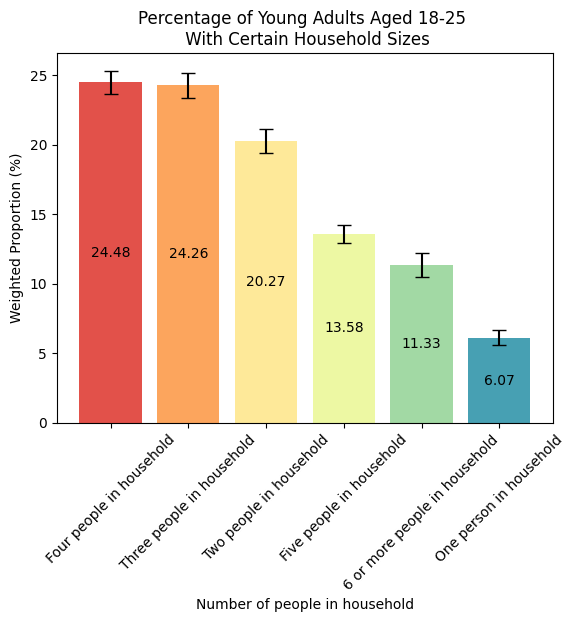

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,Four people in household,0.244843,0.004137,0.236629,0.253247,24.484268,23.662885,25.324703,0.821382,0.840435
4,subpop_xvar,Three people in household,0.242618,0.004445,0.233802,0.251657,24.261796,23.380217,25.165698,0.881579,0.903902
5,subpop_xvar,Two people in household,0.202718,0.004315,0.194190,0.211523,20.271837,19.418956,21.152345,0.852882,0.880507
1,subpop_xvar,Five people in household,0.135790,0.003291,0.129314,0.142537,13.579016,12.931446,14.253707,0.647571,0.674690
0,subpop_xvar,6 or more people in household,0.113294,0.004258,0.105018,0.122133,11.329384,10.501813,12.213271,0.827571,0.883887
3,subpop_xvar,One person in household,0.060737,0.002701,0.055533,0.066394,6.073699,5.553322,6.639409,0.520376,0.565710


In [105]:
#Examine household size frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRHHSIZ2','Number of people in household',45,"Percentage of Young Adults Aged 18-25 \n With Certain Household Sizes")

In [106]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRHHSIZ2',na_rm=True)

(      variable                       category  PopParam.count       stderror  \
 0  subpop_xvar  6 or more people in household    3.862484e+06  161498.606663   
 1  subpop_xvar       Five people in household    4.629443e+06  137360.624202   
 2  subpop_xvar       Four people in household    8.347329e+06  210802.280960   
 3  subpop_xvar        One person in household    2.070683e+06  108595.991149   
 4  subpop_xvar      Three people in household    8.271483e+06  195888.655243   
 5  subpop_xvar        Two people in household    6.911201e+06  187611.289024   
 
        lower_ci      upper_ci  
 0  3.538105e+06  4.186864e+06  
 1  4.353546e+06  4.905340e+06  
 2  7.923921e+06  8.770738e+06  
 3  1.852562e+06  2.288805e+06  
 4  7.878029e+06  8.664937e+06  
 5  6.534373e+06  7.288030e+06  ,
 subpop_xvar
 Three people in household        10500
 Two people in household          10273
 Four people in household          9135
 Five people in household          4706
 6 or more people in house

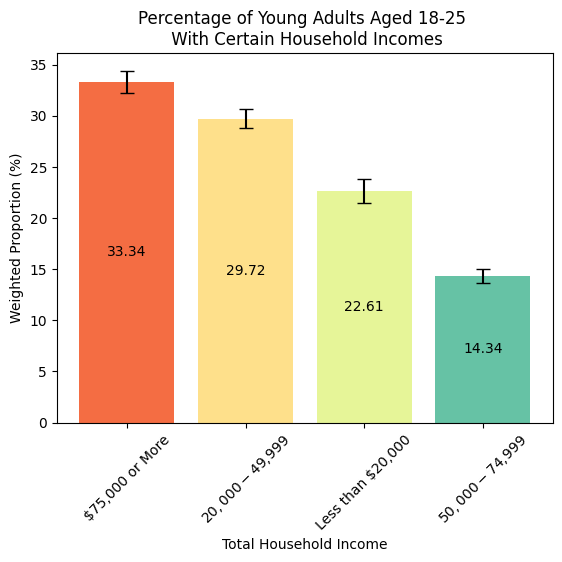

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,"$75,000 or More",0.333381,0.005366,0.322690,0.344245,33.338062,32.269022,34.424519,1.069041,1.086456
0,subpop_xvar,"$20,000-$49,999",0.297157,0.004537,0.288126,0.306349,29.715671,28.812552,30.634916,0.903119,0.919245
3,subpop_xvar,"Less than $20,000",0.226102,0.005884,0.214504,0.238138,22.610241,21.450378,23.813807,1.159863,1.203566
1,subpop_xvar,"$50,000-$74,999",0.143360,0.003566,0.136345,0.150673,14.336026,13.634512,15.067336,0.701514,0.731311


In [107]:
#Examine income frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'INCOME','Total Household Income',45,"Percentage of Young Adults Aged 18-25 \n With Certain Household Incomes")

In [108]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population) among
#Young Adults aged 18-25
frequencies(nsduh_2123,'INCOME',na_rm=True)

(      variable           category  PopParam.count       stderror  \
 0  subpop_xvar    $20,000-$49,999    1.013085e+07  250618.775372   
 1  subpop_xvar    $50,000-$74,999    4.887527e+06  139538.473998   
 2  subpop_xvar    $75,000 or More    1.136582e+07  270249.271014   
 3  subpop_xvar  Less than $20,000    7.708425e+06  247687.908503   
 
        lower_ci      upper_ci  
 0  9.627469e+06  1.063423e+07  
 1  4.607256e+06  5.167799e+06  
 2  1.082301e+07  1.190863e+07  
 3  7.210929e+06  8.205920e+06  ,
 subpop_xvar
 $20,000-$49,999      13221
 $75,000 or More      12313
 Less than $20,000    10637
 $50,000-$74,999       5702
 Name: count, dtype: int64)

# Examining Substance Use and Mental Health Patterns

In this section, we accomplish goal 2 outlined in the introduction.

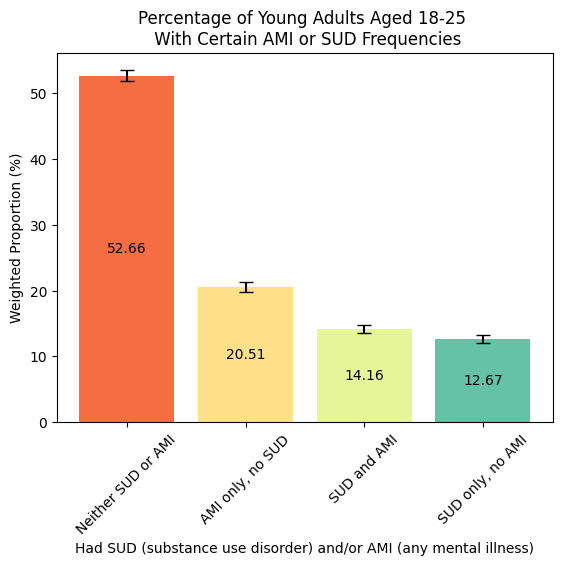

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Neither SUD or AMI,0.526573,0.003978,0.518578,0.534555,52.657321,51.857782,53.455500,0.799539,0.798179
0,subpop_xvar,"AMI only, no SUD",0.205145,0.003802,0.197613,0.212888,20.514499,19.761321,21.288767,0.753178,0.774268
2,subpop_xvar,SUD and AMI,0.141615,0.002797,0.136090,0.147326,14.161468,13.608963,14.732578,0.552505,0.571110
3,subpop_xvar,"SUD only, no AMI",0.126667,0.003010,0.120743,0.132838,12.666711,12.074307,13.283790,0.592404,0.617078


In [109]:
#Examine co-occurring substance use disorder and any mental illness frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'AMISUD5ANYO','Had SUD (substance use disorder) and/or AMI (any mental illness)',45,"Percentage of Young Adults Aged 18-25 \n With Certain AMI or SUD Frequencies")
 

In [110]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'AMISUD5ANYO',na_rm=True)

(      variable            category  PopParam.count       stderror  \
 0  subpop_xvar    AMI only, no SUD    6.993931e+06  187726.835670   
 1  subpop_xvar  Neither SUD or AMI    1.795226e+07  303977.975632   
 2  subpop_xvar         SUD and AMI    4.828016e+06  139375.863055   
 3  subpop_xvar    SUD only, no AMI    4.318414e+06  140283.204651   
 
        lower_ci      upper_ci  
 0  6.616871e+06  7.370992e+06  
 1  1.734171e+07  1.856282e+07  
 2  4.548071e+06  5.107961e+06  
 3  4.036647e+06  4.600181e+06  ,
 subpop_xvar
 Neither SUD or AMI    22507
 AMI only, no SUD       8500
 SUD and AMI            5747
 SUD only, no AMI       5119
 Name: count, dtype: int64)

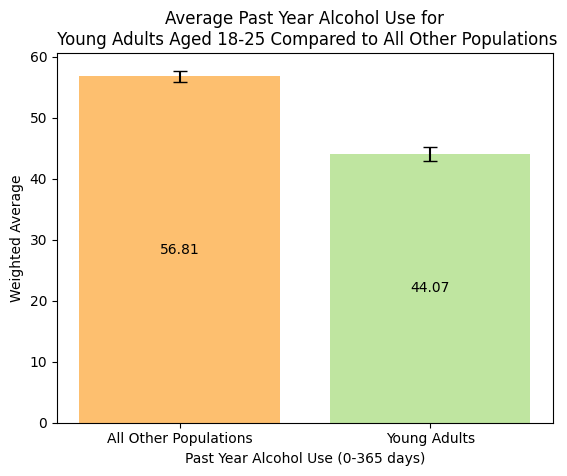

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,56.806062,0.456415,55.889327,57.722798,0.008035,0.916736,0.916736
1,PopParam.mean,Young Adults,44.068217,0.585675,42.891855,45.244579,0.013290,1.176362,1.176362


In [111]:
#Examine average of alcohol use frequency for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRALCFY",'Past Year Alcohol Use (0-365 days)',0,'Average Past Year Alcohol Use for\n Young Adults Aged 18-25 Compared to All Other Populations')

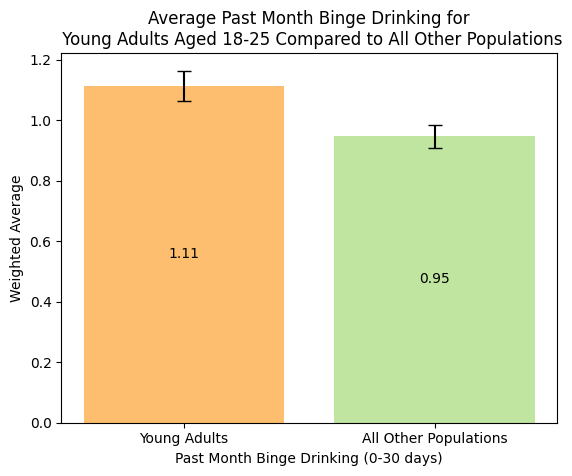

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Young Adults,1.113350,0.024803,1.063532,1.163169,0.022278,0.049819,0.049819
0,PopParam.mean,All Other Populations,0.947174,0.018881,0.909249,0.985098,0.019934,0.037924,0.037924


In [112]:
#Examine average of binge drinking frequency in the past month for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRALCBNG30D",'Past Month Binge Drinking (0-30 days)',0,'Average Past Month Binge Drinking for\n Young Adults Aged 18-25 Compared to All Other Populations')

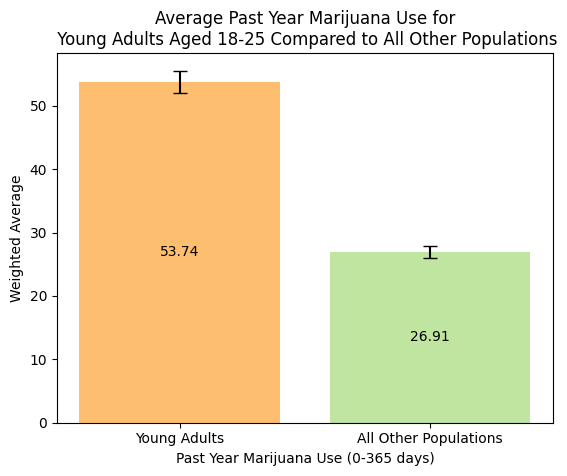

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Young Adults,53.736738,0.889279,51.950567,55.522908,0.016549,1.786170,1.786170
0,PopParam.mean,All Other Populations,26.909204,0.474157,25.956832,27.861576,0.017621,0.952372,0.952372


In [113]:
#Examine average of marijuana use frequency for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRMJFY",'Past Year Marijuana Use (0-365 days)',0,'Average Past Year Marijuana Use for\n Young Adults Aged 18-25 Compared to All Other Populations')

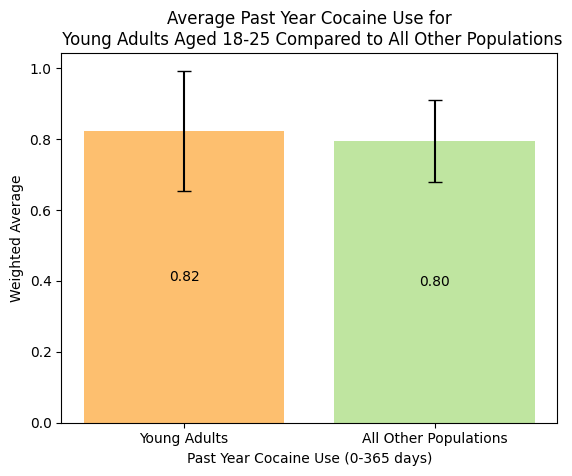

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Young Adults,0.823823,0.084377,0.654347,0.993298,0.102421,0.169476,0.169476
0,PopParam.mean,All Other Populations,0.795848,0.057550,0.680256,0.911440,0.072313,0.115592,0.115592


In [114]:
#Examine average of cocaine frequency for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRCOCFY",'Past Year Cocaine Use (0-365 days)',0,'Average Past Year Cocaine Use for\n Young Adults Aged 18-25 Compared to All Other Populations')

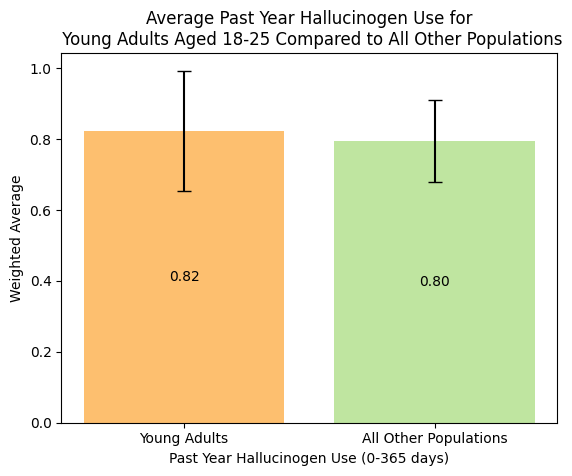

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Young Adults,0.823823,0.084377,0.654347,0.993298,0.102421,0.169476,0.169476
0,PopParam.mean,All Other Populations,0.795848,0.057550,0.680256,0.911440,0.072313,0.115592,0.115592


In [115]:
#Examine average of hallucinogen frequency for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRCOCFY",'Past Year Hallucinogen Use (0-365 days)',0,'Average Past Year Hallucinogen Use for\n Young Adults Aged 18-25 Compared to All Other Populations')

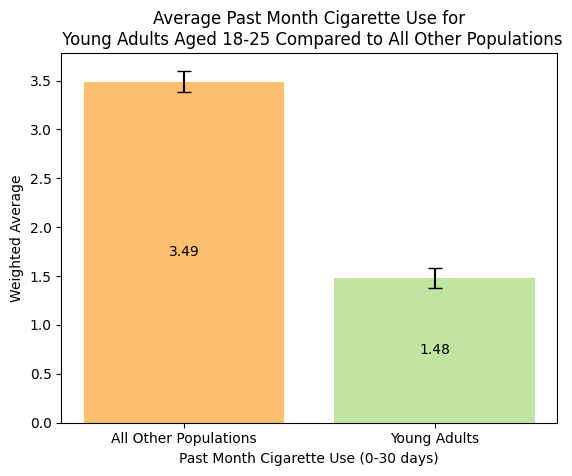

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,3.490798,0.055033,3.380261,3.601336,0.015765,0.110538,0.110538
1,PopParam.mean,Young Adults,1.480060,0.052587,1.374436,1.585684,0.035530,0.105624,0.105624


In [116]:
#Examine average of cigarette frequency in the past month for those that are Young Adults vs other populations 
mean_comp(nsduh_2123,"IRCIGFM",'Past Month Cigarette Use (0-30 days)',0,'Average Past Month Cigarette Use for\n Young Adults Aged 18-25 Compared to All Other Populations')

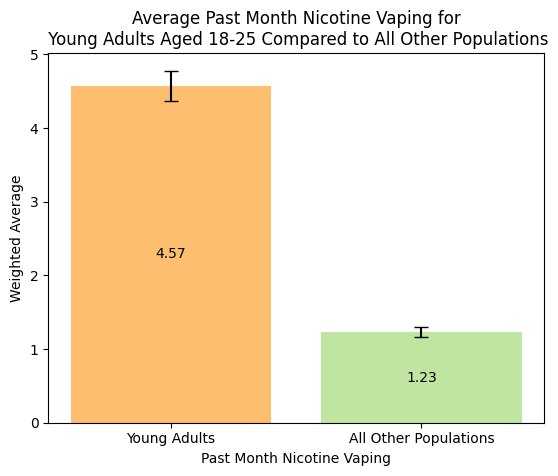

          _param                _domain  _estimate  _stderror      _lci  \
1  PopParam.mean           Young Adults   4.569073   0.103696  4.360794   
0  PopParam.mean  All Other Populations   1.227072   0.033015  1.160758   

       _uci       _cv  lower_error  upper_error  
1  4.777352  0.022695     0.208279     0.208279  
0  1.293385  0.026906     0.066313     0.066313  


In [117]:
#Examine average of nicotine vaping frequency in the past month for those that are Young Adults vs other populations 
df=nsduh_2123.copy()
df=df[df['IRNICVAP30N'] != -9] 
#Obtain averages table
df=avg_tbl(df,'IRNICVAP30N',na_rm=True)
#Create new column that calculates the lower error based on the average subtracted to the _lci
df['lower_error']=df['_estimate']-df['_lci']
    #Create new column that calculates the upper error based on the average subtracted to the _uci
df['upper_error']=df['_uci']-df['_estimate']
#Put lower and upper measures into a list
asymmetric_err=[df['lower_error'],df['upper_error']]
#Create bar plot with error bars
plot=plt.bar(df['_domain'],df['_estimate'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
#Add data labels to bar plot
plt.bar_label(plot,fmt="%.2f",label_type='center')
#Change x-axis label of plot
plt.xlabel('Past Month Nicotine Vaping')
#Change y-axis label of plot
plt.ylabel("Weighted Average")
#Change title of plot
plt.title('Average Past Month Nicotine Vaping for\n Young Adults Aged 18-25 Compared to All Other Populations')
#Change rotation angle of x-axis tick labels of plot
plt.xticks(rotation=0)
#Show plot
plt.show()
#Print averages table
print(df)


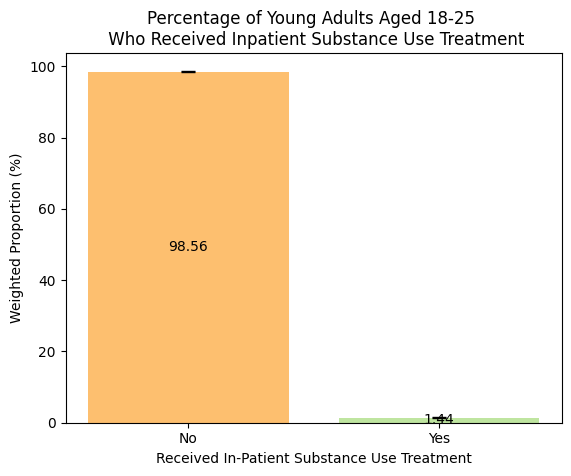

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.985584,0.001213,0.982935,0.987827,98.558426,98.293477,98.782749,0.264949,0.224323
1,subpop_xvar,Yes,0.014416,0.001213,0.012173,0.017065,1.441574,1.217251,1.706523,0.224323,0.264949


In [118]:
#Examine substance use treatment frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'SUTINPPY','Received In-Patient Substance Use Treatment',0,"Percentage of Young Adults Aged 18-25 \n Who Received Inpatient Substance Use Treatment")

In [119]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'SUTINPPY',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar       No    2.260912e+07  439713.018852  2.172593e+07   
 1  subpop_xvar      Yes    3.306945e+05   30010.489391  2.704167e+05   
 
        upper_ci  
 0  2.349231e+07  
 1  3.909723e+05  ,
 subpop_xvar
 No     27434
 Yes      460
 Name: count, dtype: int64)

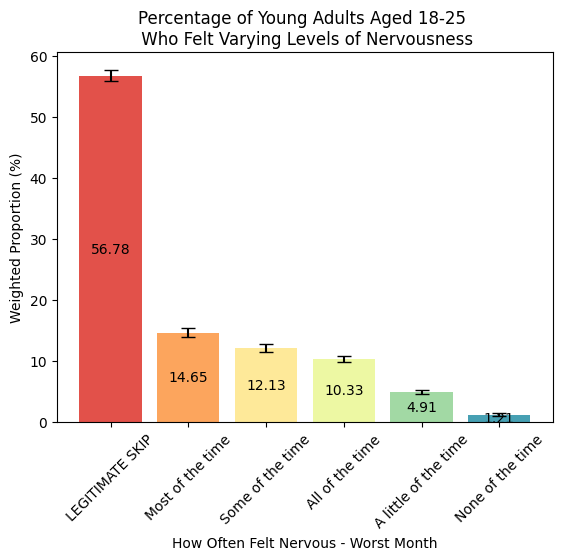

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,LEGITIMATE SKIP,0.567766,0.004670,0.558364,0.577120,56.776615,55.836376,57.711997,0.940239,0.935382
3,subpop_xvar,Most of the time,0.146507,0.003411,0.139788,0.153491,14.650652,13.978773,15.349062,0.671879,0.698410
5,subpop_xvar,Some of the time,0.121291,0.003272,0.114871,0.128017,12.129065,11.487093,12.801724,0.641971,0.672660
1,subpop_xvar,All of the time,0.103272,0.002500,0.098357,0.108404,10.327248,9.835747,10.840357,0.491501,0.513109
0,subpop_xvar,A little of the time,0.049107,0.001596,0.045999,0.052415,4.910742,4.599879,5.241460,0.310864,0.330718
4,subpop_xvar,None of the time,0.012057,0.000957,0.010278,0.014139,1.205678,1.027835,1.413852,0.177843,0.208175


In [120]:
#Examine past year feeling nervous frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRDSTNRV12','How Often Felt Nervous - Worst Month',45,"Percentage of Young Adults Aged 18-25 \n Who Felt Varying Levels of Nervousness")

In [121]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRDSTNRV12',na_rm=True)

(      variable              category  PopParam.count       stderror  \
 0  subpop_xvar  A little of the time    1.674201e+06   67730.439033   
 1  subpop_xvar       All of the time    3.520830e+06  115965.504716   
 2  subpop_xvar       LEGITIMATE SKIP    1.935664e+07  357256.933541   
 3  subpop_xvar      Most of the time    4.994792e+06  160234.700703   
 4  subpop_xvar      None of the time    4.110472e+05   32594.932312   
 5  subpop_xvar      Some of the time    4.135116e+06  121788.894742   
 
        lower_ci      upper_ci  
 0  1.538160e+06  1.810242e+06  
 1  3.287906e+06  3.753754e+06  
 2  1.863907e+07  2.007421e+07  
 3  4.672951e+06  5.316633e+06  
 4  3.455783e+05  4.765160e+05  
 5  3.890496e+06  4.379737e+06  ,
 subpop_xvar
 LEGITIMATE SKIP         24004
 Most of the time         6053
 Some of the time         5107
 All of the time          4020
 A little of the time     2168
 None of the time          521
 Name: count, dtype: int64)

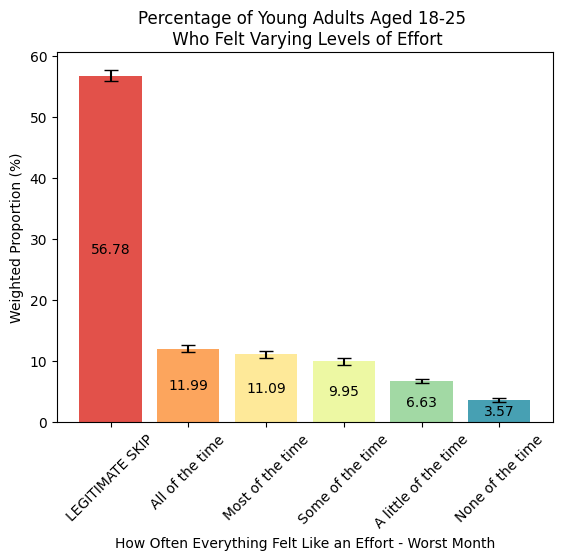

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,LEGITIMATE SKIP,0.567766,0.004670,0.558364,0.577120,56.776615,55.836376,57.711997,0.940239,0.935382
1,subpop_xvar,All of the time,0.119859,0.003061,0.113845,0.126145,11.985891,11.384503,12.614524,0.601387,0.628633
3,subpop_xvar,Most of the time,0.110896,0.002796,0.105402,0.116638,11.089577,10.540234,11.663819,0.549343,0.574241
5,subpop_xvar,Some of the time,0.099469,0.002749,0.094083,0.105129,9.946932,9.408271,10.512856,0.538662,0.565923
0,subpop_xvar,A little of the time,0.066321,0.001631,0.063119,0.069673,6.632068,6.311907,6.967261,0.320161,0.335193
4,subpop_xvar,None of the time,0.035689,0.001617,0.032579,0.039084,3.568917,3.257905,3.908419,0.311011,0.339502


In [122]:
#Examine past year everything felt like an effort frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRDSTEFF12','How Often Everything Felt Like an Effort - Worst Month',45,"Percentage of Young Adults Aged 18-25 \n Who Felt Varying Levels of Effort")

In [123]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRDSTEFF12',na_rm=True)

(      variable              category  PopParam.count       stderror  \
 0  subpop_xvar  A little of the time    2.261046e+06   76877.035020   
 1  subpop_xvar       All of the time    4.086305e+06  138381.753498   
 2  subpop_xvar       LEGITIMATE SKIP    1.935664e+07  357256.933541   
 3  subpop_xvar      Most of the time    3.780728e+06  116069.837931   
 4  subpop_xvar      None of the time    1.216737e+06   57459.172568   
 5  subpop_xvar      Some of the time    3.391170e+06  111743.298759   
 
        lower_ci      upper_ci  
 0  2.106634e+06  2.415458e+06  
 1  3.808357e+06  4.364253e+06  
 2  1.863907e+07  2.007421e+07  
 3  3.547595e+06  4.013861e+06  
 4  1.101327e+06  1.332148e+06  
 5  3.166727e+06  3.615613e+06  ,
 subpop_xvar
 LEGITIMATE SKIP         24004
 All of the time          4787
 Most of the time         4700
 Some of the time         4119
 A little of the time     2786
 None of the time         1477
 Name: count, dtype: int64)

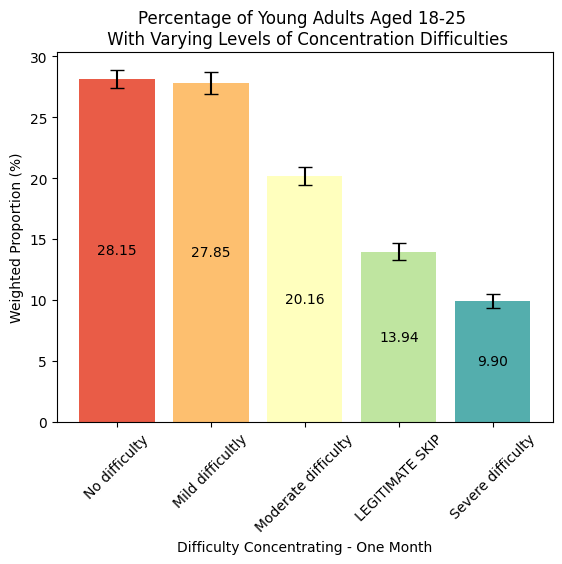

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
3,subpop_xvar,No difficulty,0.281504,0.003651,0.274229,0.288895,28.150354,27.422851,28.889476,0.727504,0.739121
1,subpop_xvar,Mild difficultly,0.278500,0.004468,0.269616,0.287562,27.850036,26.961603,28.756218,0.888433,0.906182
2,subpop_xvar,Moderate difficulty,0.201573,0.003683,0.194277,0.209072,20.157330,19.427741,20.907209,0.729589,0.749879
0,subpop_xvar,LEGITIMATE SKIP,0.139438,0.003467,0.132618,0.146549,13.943768,13.261802,14.654878,0.681966,0.711110
4,subpop_xvar,Severe difficulty,0.098985,0.002774,0.093551,0.104698,9.898511,9.355121,10.469819,0.543391,0.571308


In [124]:
#Examine past year difficulty concentrating frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRIMPCONCN','Difficulty Concentrating - One Month',45,"Percentage of Young Adults Aged 18-25 \n With Varying Levels of Concentration Difficulties")

In [125]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRIMPCONCN',na_rm=True)

(      variable             category  PopParam.count       stderror  \
 0  subpop_xvar      LEGITIMATE SKIP    4.753796e+06  137508.323598   
 1  subpop_xvar     Mild difficultly    9.494808e+06  246975.762022   
 2  subpop_xvar  Moderate difficulty    6.872163e+06  162458.730558   
 3  subpop_xvar        No difficulty    9.597195e+06  187333.588219   
 4  subpop_xvar    Severe difficulty    3.374662e+06  130676.615549   
 
        lower_ci      upper_ci  
 0  4.477603e+06  5.029990e+06  
 1  8.998743e+06  9.990874e+06  
 2  6.545855e+06  7.198471e+06  
 3  9.220924e+06  9.973465e+06  
 4  3.112191e+06  3.637134e+06  ,
 subpop_xvar
 No difficulty          11866
 Mild difficultly       11592
 Moderate difficulty     8274
 LEGITIMATE SKIP         6181
 Severe difficulty       3960
 Name: count, dtype: int64)

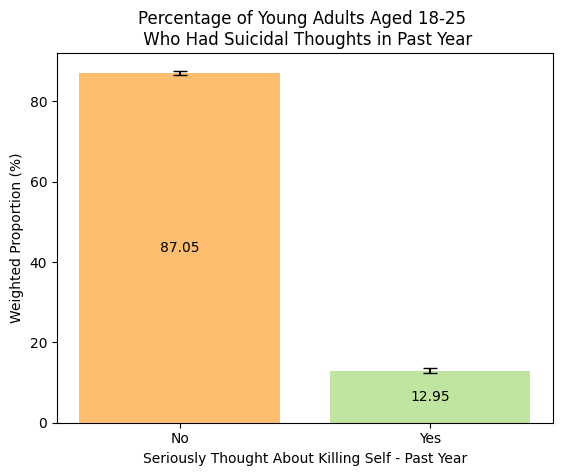

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.870522,0.002916,0.864551,0.876267,87.052161,86.455097,87.626673,0.597064,0.574512
1,subpop_xvar,Yes,0.129478,0.002916,0.123733,0.135449,12.947839,12.373327,13.544903,0.574512,0.597064


In [126]:
#Examine past year suicidal thoughts frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRSUICTHNK','Seriously Thought About Killing Self - Past Year',0,"Percentage of Young Adults Aged 18-25 \n Who Had Suicidal Thoughts in Past Year")

In [127]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRSUICTHNK',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar       No    2.967837e+07  543077.181926  2.858756e+07   
 1  subpop_xvar      Yes    4.414258e+06  126963.758694  4.159244e+06   
 
        upper_ci  
 0  3.076917e+07  
 1  4.669272e+06  ,
 subpop_xvar
 No     36570
 Yes     5303
 Name: count, dtype: int64)

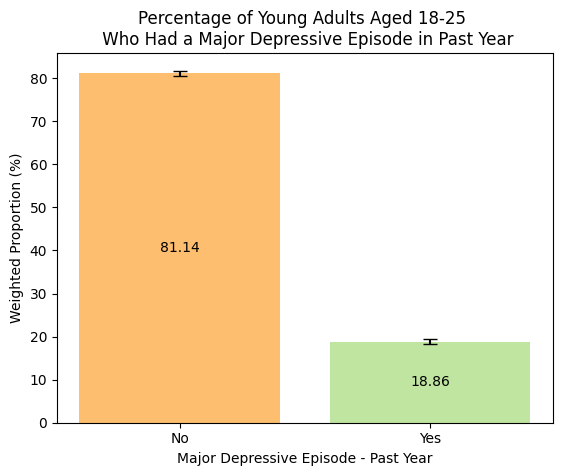

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.811383,0.003074,0.80513,0.81748,81.138256,80.512985,81.748012,0.625271,0.609756
1,subpop_xvar,Yes,0.188617,0.003074,0.18252,0.19487,18.861744,18.251988,19.487015,0.609756,0.625271


In [128]:
#Examine past year major depressive episode frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'IRAMDEYR','Major Depressive Episode - Past Year',0,"Percentage of Young Adults Aged 18-25 \n Who Had a Major Depressive Episode in Past Year")

In [129]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'IRAMDEYR',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar       No    2.766216e+07  482845.740117  2.669234e+07   
 1  subpop_xvar      Yes    6.430464e+06  173751.904054  6.081473e+06   
 
        upper_ci  
 0  2.863199e+07  
 1  6.779455e+06  ,
 subpop_xvar
 No     34358
 Yes     7515
 Name: count, dtype: int64)

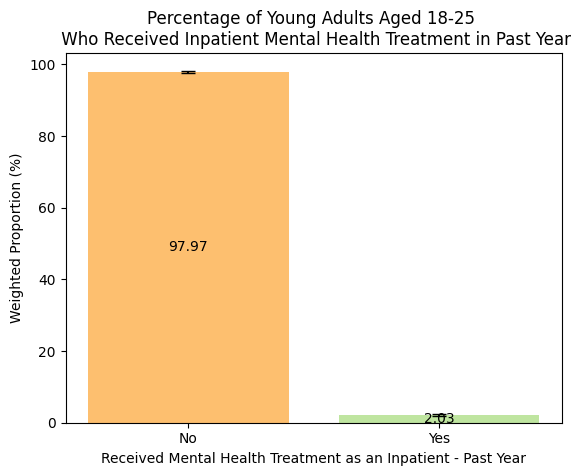

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.979746,0.001267,0.977038,0.982141,97.974618,97.703799,98.214079,0.270819,0.239461
1,subpop_xvar,Yes,0.020254,0.001267,0.017859,0.022962,2.025382,1.785921,2.296201,0.239461,0.270819


In [130]:
#Examine past year receipt of inpatient mental health treatment frequencies among Young Adults aged 18-25
rel_freq_barplot(nsduh_2123,'MHTINPPY','Received Mental Health Treatment as an Inpatient - Past Year',0,"Percentage of Young Adults Aged 18-25 \n Who Received Inpatient Mental Health Treatment in Past Year")

In [131]:
#Compute counts/frequencies (weighted to represent the totals for Young Adults in the U.S. population)
frequencies(nsduh_2123,'MHTINPPY',na_rm=True)

(      variable category  PopParam.count       stderror      lower_ci  \
 0  subpop_xvar       No    2.247519e+07  436655.513439  2.159815e+07   
 1  subpop_xvar      Yes    4.646189e+05   32506.425835  3.993278e+05   
 
        upper_ci  
 0  2.335224e+07  
 1  5.299100e+05  ,
 subpop_xvar
 No     27231
 Yes      663
 Name: count, dtype: int64)

# Associations between our confounders and mental health

In this section, we accomplish goal 3 outlined in the introduction.

In [132]:
#Define variables
df=nsduh_2123
xvar='IRSEX'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)



C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\1051062921.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable category  PopParam.prop  stderror  lower_ci  upper_ci
0  subpop_xvar   Female       0.590127  0.011917  0.565995  0.613833
1  subpop_xvar     Male       0.409873  0.011917  0.386167  0.434005
      variable category  PopParam.prop  stderror  lower_ci  upper_ci
1  subpop_xvar     Male       0.514994  0.004634  0.505683  0.524295
0  subpop_xvar   Female       0.485006  0.004634  0.475705  0.494317


In [133]:
#Define variables
df=nsduh_2123
xvar='NEWRACE2'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\3979586064.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable                         category  PopParam.prop  stderror  \
6  subpop_xvar                    Nonhisp White       0.565910  0.012983   
0  subpop_xvar                         Hispanic       0.207337  0.011598   
2  subpop_xvar             NonHisp Black/Afr Am       0.118312  0.009226   
1  subpop_xvar                    NonHisp Asian       0.056075  0.006521   
5  subpop_xvar       NonHisp more than one race       0.038953  0.003997   
3  subpop_xvar      NonHisp Native Am/AK Native       0.009822  0.002239   
4  subpop_xvar  NonHisp Native HI/Other Pac Isl       0.003592  0.001319   

   lower_ci  upper_ci  
6  0.539675  0.591781  
0  0.185005  0.231599  
2  0.101001  0.138134  
1  0.044327  0.070706  
5  0.031672  0.047824  
3  0.006208  0.015507  
4  0.001716  0.007502  
      variable                         category  PopParam.prop  stderror  \
6  subpop_xvar                    Nonhisp White       0.518022  0.006399   
0  subpop_xvar                         Hispanic

In [134]:
#Define variables
df=nsduh_2123
xvar='EDUHIGHCAT'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\3433867831.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable            category  PopParam.prop  stderror  lower_ci  \
3  subpop_xvar  Some coll/Assoc Dg       0.424219  0.011281  0.401735   
1  subpop_xvar    High school grad       0.343804  0.011432  0.321221   
0  subpop_xvar    College graduate       0.120968  0.008170  0.105495   
2  subpop_xvar    Less high school       0.111008  0.007335  0.097109   

   upper_ci  
3  0.447022  
1  0.367117  
0  0.138361  
2  0.126618  
      variable            category  PopParam.prop  stderror  lower_ci  \
3  subpop_xvar  Some coll/Assoc Dg       0.397893  0.005229  0.387439   
1  subpop_xvar    High school grad       0.327570  0.004174  0.319242   
0  subpop_xvar    College graduate       0.169386  0.003925  0.161649   
2  subpop_xvar    Less high school       0.105150  0.002954  0.099364   

   upper_ci  
3  0.408442  
1  0.336008  
0  0.177415  
2  0.111232  


In [135]:
#Define variables
df=nsduh_2123
xvar='IRWRKSTAT18'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\4073733344.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable                          category  PopParam.prop  stderror  \
0  subpop_xvar                Employed full time       0.389281  0.011945   
1  subpop_xvar                Employed part time       0.278015  0.010130   
2  subpop_xvar  Other (incl. not in labor force)       0.226638  0.010714   
3  subpop_xvar                        Unemployed       0.106065  0.007741   

   lower_ci  upper_ci  
0  0.365574  0.413524  
1  0.258133  0.298813  
2  0.205842  0.248878  
3  0.091491  0.122647  
      variable                          category  PopParam.prop  stderror  \
0  subpop_xvar                Employed full time       0.398695  0.004377   
2  subpop_xvar  Other (incl. not in labor force)       0.264848  0.004021   
1  subpop_xvar                Employed part time       0.242405  0.004280   
3  subpop_xvar                        Unemployed       0.094052  0.002378   

   lower_ci  upper_ci  
0  0.389938  0.407518  
2  0.256852  0.273002  
1  0.233913  0.251105  
3  0.089384 

In [136]:
#Define variables
df=nsduh_2123
xvar='IRPRVHLT'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\4131802292.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable category  PopParam.prop  stderror  lower_ci  upper_ci
1  subpop_xvar      Yes        0.58914  0.011891  0.565064  0.612796
0  subpop_xvar       No        0.41086  0.011891  0.387204  0.434936
      variable category  PopParam.prop  stderror  lower_ci  upper_ci
1  subpop_xvar      Yes       0.563155  0.005151  0.552782  0.573472
0  subpop_xvar       No       0.436845  0.005151  0.426528  0.447218


In [137]:
#Define variables
df=nsduh_2123
xvar='IRHHSIZ2'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\1892658524.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable                       category  PopParam.prop  stderror  \
4  subpop_xvar      Three people in household       0.257590  0.011136   
2  subpop_xvar       Four people in household       0.226430  0.010957   
5  subpop_xvar        Two people in household       0.221929  0.009602   
1  subpop_xvar       Five people in household       0.123508  0.009025   
0  subpop_xvar  6 or more people in household       0.098734  0.006646   
3  subpop_xvar        One person in household       0.071809  0.006292   

   lower_ci  upper_ci  
4  0.235863  0.280582  
2  0.205181  0.249190  
5  0.203243  0.241812  
1  0.106494  0.142806  
0  0.086165  0.112910  
3  0.060153  0.085518  
      variable                       category  PopParam.prop  stderror  \
2  subpop_xvar       Four people in household       0.247581  0.003935   
4  subpop_xvar      Three people in household       0.240391  0.004454   
5  subpop_xvar        Two people in household       0.199861  0.004558   
1  subpop_xvar   

In [138]:
#Define variables
df=nsduh_2123
xvar='INCOME'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\35456370.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable           category  PopParam.prop  stderror  lower_ci  upper_ci
0  subpop_xvar    $20,000-$49,999       0.317480  0.012947  0.292062  0.344035
2  subpop_xvar    $75,000 or More       0.311257  0.009264  0.292962  0.330162
3  subpop_xvar  Less than $20,000       0.232293  0.012172  0.208746  0.257630
1  subpop_xvar    $50,000-$74,999       0.138970  0.010119  0.119864  0.160567
      variable           category  PopParam.prop  stderror  lower_ci  upper_ci
2  subpop_xvar    $75,000 or More       0.336671  0.006052  0.324625  0.348933
0  subpop_xvar    $20,000-$49,999       0.294134  0.004934  0.284322  0.304141
3  subpop_xvar  Less than $20,000       0.225182  0.005971  0.213415  0.237401
1  subpop_xvar    $50,000-$74,999       0.144013  0.003568  0.136994  0.151329


In [139]:
#Define variables
df=nsduh_2123
xvar='IRDSTNRV12'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\3578626191.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable              category  PopParam.prop  stderror  lower_ci  \
1  subpop_xvar       All of the time       0.354678  0.011345  0.332234   
3  subpop_xvar      Most of the time       0.264387  0.010390  0.244053   
2  subpop_xvar       LEGITIMATE SKIP       0.219339  0.010565  0.198857   
5  subpop_xvar      Some of the time       0.109806  0.007815  0.095064   
0  subpop_xvar  A little of the time       0.041297  0.005316  0.031845   
4  subpop_xvar      None of the time       0.010492  0.002344  0.006693   

   upper_ci  
1  0.377781  
3  0.285776  
2  0.241295  
5  0.126515  
0  0.053399  
4  0.016414  
      variable              category  PopParam.prop  stderror  lower_ci  \
2  subpop_xvar       LEGITIMATE SKIP       0.619590  0.004785  0.609934   
3  subpop_xvar      Most of the time       0.128973  0.003549  0.122011   
5  subpop_xvar      Some of the time       0.122999  0.003573  0.116000   
1  subpop_xvar       All of the time       0.065879  0.002092  0.061800   
0

In [140]:
#Define variables
df=nsduh_2123
xvar='IRDSTEFF12'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\3078295548.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable              category  PopParam.prop  stderror  lower_ci  \
1  subpop_xvar       All of the time       0.431887  0.010366  0.411198   
2  subpop_xvar       LEGITIMATE SKIP       0.219339  0.010565  0.198857   
3  subpop_xvar      Most of the time       0.195801  0.009129  0.178111   
5  subpop_xvar      Some of the time       0.096127  0.006905  0.083125   
0  subpop_xvar  A little of the time       0.038507  0.005217  0.029294   
4  subpop_xvar      None of the time       0.018339  0.003109  0.013034   

   upper_ci  
1  0.452817  
2  0.241295  
3  0.214789  
5  0.110918  
0  0.050468  
4  0.025746  
      variable              category  PopParam.prop  stderror  lower_ci  \
2  subpop_xvar       LEGITIMATE SKIP       0.619590  0.004785  0.609934   
5  subpop_xvar      Some of the time       0.099966  0.002936  0.094222   
3  subpop_xvar      Most of the time       0.098267  0.002928  0.092541   
1  subpop_xvar       All of the time       0.073449  0.002771  0.068074   
0

In [141]:
#Define variables
df=nsduh_2123
xvar='IRIMPCONCN'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\2080972309.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable             category  PopParam.prop  stderror  lower_ci  \
2  subpop_xvar  Moderate difficulty       0.344226  0.012780  0.319030   
4  subpop_xvar    Severe difficulty       0.298741  0.009191  0.280613   
1  subpop_xvar     Mild difficultly       0.239554  0.010708  0.218711   
3  subpop_xvar        No difficulty       0.113458  0.007360  0.099493   
0  subpop_xvar      LEGITIMATE SKIP       0.004020  0.001624  0.001784   

   upper_ci  
2  0.370330  
4  0.317524  
1  0.261718  
3  0.129102  
0  0.009032  
      variable             category  PopParam.prop  stderror  lower_ci  \
3  subpop_xvar        No difficulty       0.306498  0.004074  0.298378   
1  subpop_xvar     Mild difficultly       0.284293  0.004889  0.274577   
2  subpop_xvar  Moderate difficulty       0.180356  0.003658  0.173125   
0  subpop_xvar      LEGITIMATE SKIP       0.159579  0.003798  0.152098   
4  subpop_xvar    Severe difficulty       0.069274  0.002357  0.064686   

   upper_ci  
3  0.314740 

In [142]:
#Define variables
df=nsduh_2123
xvar='SUTINPPY'
na_rm=True
#Work on a copy to avoid modifying original df
df = df.copy()
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create new column based on where there are young adults in the cleaned dataset and where there are people that had suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 1), np.nan)
#Tabulation function calculates and tabulates summary statistics of a categorical variable given
#survey weights and survey design measures
#We account for the subpopulation (Young Adults) WHEN we do the tabulation 
#Don't filter data down to Young Adults before doing the tabulation as 
#that would bias the SE/variance estimates towards that specific subgroup rather than the total population
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df1=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df1.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Create new column based on where there are young adults in the cleaned dataset and where there are people that didn't have suicial thoughts in the cleaned dataset
df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df['IRSUICTHNK'] == 0), np.nan)
#Tabulation with full dataset, but subpopulation defined
tab = Tabulation(PopParam.prop)  
tab.tabulate(
#Column we want to tabulate relative frequencies based on 
vars=df[["subpop_xvar"]],
#2023 NSDUH sample weight
samp_weight=df["ANALWT2_C3"],
#Variance stratum
stratum=df["VESTR_C"],
#Variance primary sampling unit
psu=df["VEREP"],
remove_nan=na_rm
    )
#Convert the weighted frequency estimates to a dataframe
df2=tab.to_dataframe()
#Sort the frequency dataframe by frequencies in descending order
df2.sort_values(by=PopParam.prop,ascending=False,inplace=True)
#Display first dataframe
print(df1)
#Display second dataframe
print(df2)

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\981960346.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


      variable category  PopParam.prop  stderror  lower_ci  upper_ci
0  subpop_xvar       No       0.959313  0.004603  0.948993  0.967616
1  subpop_xvar      Yes       0.040687  0.004603  0.032384  0.051007
      variable category  PopParam.prop  stderror  lower_ci  upper_ci
0  subpop_xvar       No       0.989467  0.001124  0.986953  0.991501
1  subpop_xvar      Yes       0.010533  0.001124  0.008499  0.013047


In [143]:
avg_tbl3(df,'IRALCFY','IRSUICTHNK',na_rm=True)

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
1,PopParam.mean,Yes,57.328172,1.572592,54.169527,60.486817,0.027431
1,PopParam.mean,No,42.095977,0.636557,40.817414,43.374540,0.015122


In [144]:
avg_tbl3(df,'IRCIGFM','IRSUICTHNK',na_rm=True)

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
1,PopParam.mean,Yes,2.584386,0.158224,2.266584,2.902188,0.061223
1,PopParam.mean,No,1.315806,0.052314,1.210730,1.420882,0.039758


In [145]:
avg_tbl3(df,'IRALCBNG30D','IRSUICTHNK',na_rm=True)

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
1,PopParam.mean,Yes,1.587821,0.084290,1.418520,1.757123,0.053085
1,PopParam.mean,No,1.042779,0.026808,0.988934,1.096625,0.025708


In [146]:
#Examine average of nicotine vaping frequency in the past month for those that are Young Adults with suicidal thoughts
#vs young adults without suicidal thoughts 
#Create copy of nsduh dataframe
df=nsduh_2123.copy()
#Filter values of -9 out of the column
df=df[df['IRNICVAP30N'] != -9] 
#Recode suicidal ideation variable
df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})
#Create domain series for Young Adults who have experienced the specified mental health issue (yvar)
domain_yes = ((df["CATAGE"]==2) & (df['IRSUICTHNK']==1)).astype(int)
#Taylor estimator for mean substance use frequency for mental health group 1 (Young Adults 
#who experienced the mental health issue in the past year)
est = TaylorEstimator(PopParam.mean)
est.estimate(
        y=df['IRNICVAP30N'],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_yes,
        remove_nan=na_rm
    )
#to_dataframe() is handy when domain is provided (row per domain level)
out1 = est.to_dataframe()
#Change values of domain column to be more descriptive
out1['_domain'] = out1['_domain'].replace({1: 'Yes', 0: 'All Other Populations'})
#Create domain series for Young Adults who have NOT experienced the specified mental health issue (yvar)
domain_no = ((df["CATAGE"]==2) & (df['IRSUICTHNK']==0)).astype(int)
#Taylor estimator for mean substance use frequency for mental health group 2 (multiracial young 
#adults who did not experience the mental health issue in the past year)
est = TaylorEstimator(PopParam.mean)
est.estimate(
        y=df['IRNICVAP30N'],
        samp_weight=df["ANALWT2_C3"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_no,
        remove_nan=na_rm
    )
#to_dataframe() is handy when domain is provided (row per domain level)
out2 = est.to_dataframe()
#Change values of domain column to be more descriptive
out2['_domain'] = out2['_domain'].replace({1: 'No', 0: 'All Other Populations'})
#Combine the two dataframes, taking the row of each dataframe where _domain=Group 1 or _domain=Group 2
group_comp=pd.concat([out1.loc[out1['_domain']=='Yes',:],out2.loc[out2['_domain']=='No',:]])
#Sort the combined dataframe
group_comp.sort_values(by='_estimate',ascending=False,inplace=True)
#Return dataframe with mean (accounts for complex survey design) substance use for each group
group_comp

C:\Users\John Platt\AppData\Local\Temp\ipykernel_16288\8278840.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IRSUICTHNK']=df['IRSUICTHNK'].replace({'Yes':1,'No':0})


,_param,_domain,_estimate,_stderror,_lci,_uci,_cv
1,PopParam.mean,Yes,7.168635,0.263226,6.639929,7.697341,0.036719
1,PopParam.mean,No,4.184867,0.115721,3.952434,4.417300,0.027652


# Initial Associations Between Substance Use and Mental Health

In this section, we accomplish goal 4 outlined in the introduction.

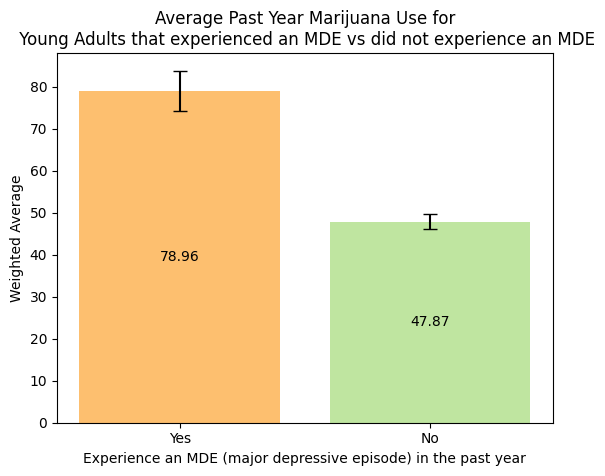

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,78.963009,2.399323,74.143827,83.782192,0.030385,4.819182,4.819182
1,PopParam.mean,No,47.872531,0.924687,46.015243,49.729819,0.019316,1.857288,1.857288


In [147]:
#Estimate average yearly marijuana use among Young Adults who experienced an MDE in the past year
#vs Young Adults who did not experience an MDE in the past year
mean_comp2(nsduh_2123,'IRMJFY','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Marijuana Use for\n Young Adults that experienced an MDE vs did not experience an MDE')

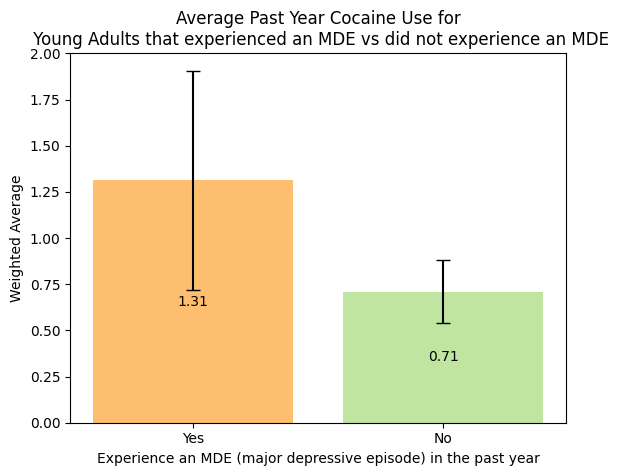

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,1.312274,0.295913,0.717916,1.906632,0.225496,0.594358,0.594358
1,PopParam.mean,No,0.710275,0.085579,0.538384,0.882166,0.120488,0.171891,0.171891


In [148]:
#Estimate average yearly cocaine use among Young Adults who experienced an MDE in the past year
#vs Young Adults who did not experience an MDE in the past year
mean_comp2(nsduh_2123,'IRCOCFY','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Cocaine Use for\n Young Adults that experienced an MDE vs did not experience an MDE')

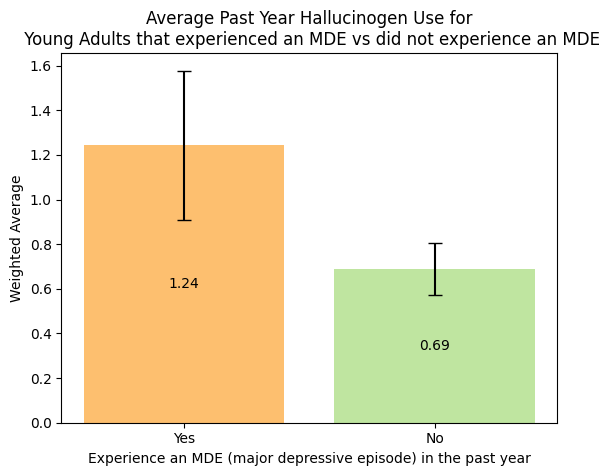

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,1.243688,0.166220,0.909826,1.57755,0.133651,0.333862,0.333862
1,PopParam.mean,No,0.689203,0.057328,0.574056,0.80435,0.083180,0.115147,0.115147


In [149]:
#Estimate average yearly hallucinogen use among Young Adults who experienced an MDE in the past year
#vs Young Adults who did not experience an MDE in the past year
mean_comp2(nsduh_2123,'IRHALLUCYFQ','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Hallucinogen Use for\n Young Adults that experienced an MDE vs did not experience an MDE')

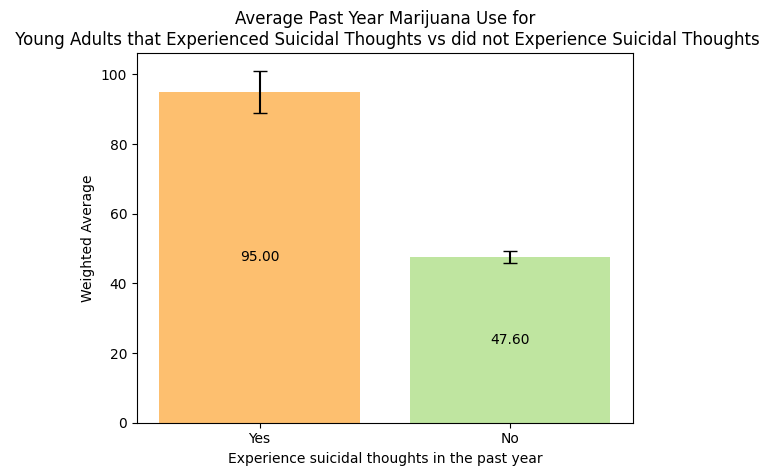

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,94.998547,3.014565,88.943616,101.053479,0.031733,6.054931,6.054931
1,PopParam.mean,No,47.599598,0.867477,45.857218,49.341978,0.018224,1.742380,1.742380


In [150]:
#Estimate average yearly marijuana use among Young Adults who experienced suicidal thoughts in the past year
#vs Young Adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2123,'IRMJFY','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Marijuana Use for\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

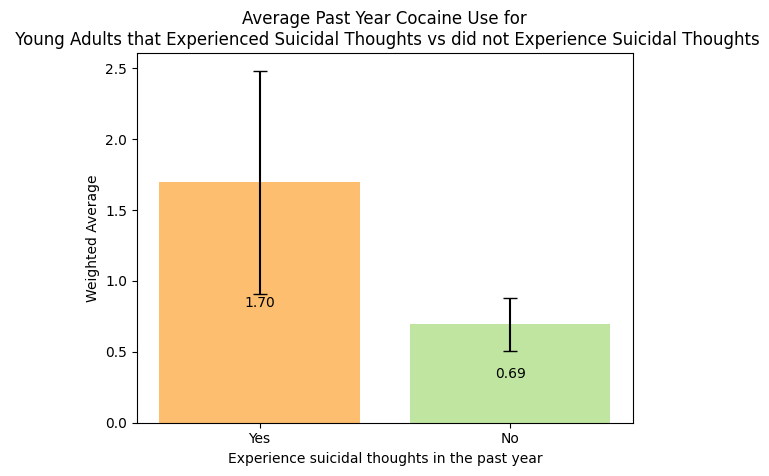

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,1.695783,0.392157,0.908113,2.483454,0.231254,0.787670,0.787670
1,PopParam.mean,No,0.694130,0.092483,0.508372,0.879888,0.133236,0.185758,0.185758


In [151]:
#Estimate average yearly cocaine use among Young Adults who experienced suicidal thoughts in the past year
#vs Young Adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2123,'IRCOCFY','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Cocaine Use for\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

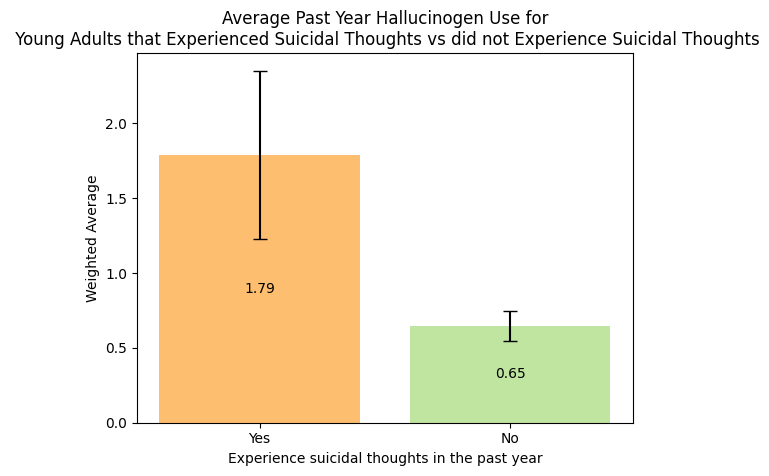

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,1.790958,0.279273,1.230022,2.351893,0.155935,0.560936,0.560936
1,PopParam.mean,No,0.645473,0.051017,0.543002,0.747944,0.079038,0.102471,0.102471


In [152]:
#Estimate average yearly hallucinogen use among Young Adults who experienced suicidal thoughts in the past year
#vs Young Adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2123,'IRHALLUCYFQ','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Hallucinogen Use for\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

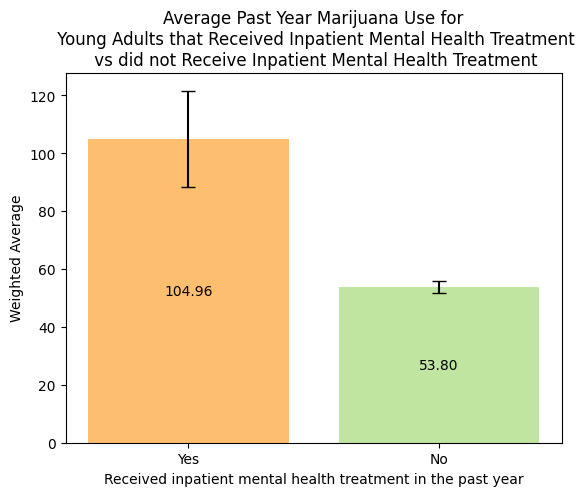

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,104.959314,8.274651,88.339189,121.579439,0.078837,16.620125,16.620125
1,PopParam.mean,No,53.799176,1.097122,51.595543,56.002810,0.020393,2.203634,2.203634


In [153]:
#Estimate average yearly marijuana use among Young Adults who received inpatient mental health treatment in the past year
#vs Young Adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2123,'IRMJFY','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Marijuana Use for\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

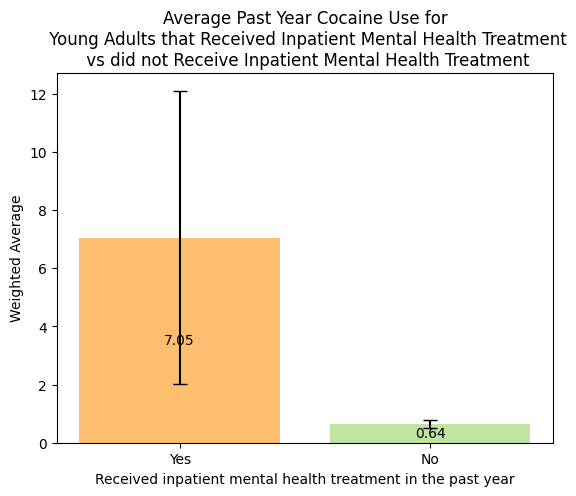

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,7.052466,2.511836,2.007294,12.097637,0.356164,5.045171,5.045171
1,PopParam.mean,No,0.641732,0.067793,0.505565,0.777899,0.105641,0.136167,0.136167


In [154]:
#Estimate average yearly cocaine use among Young Adults who received inpatient mental health treatment in the past year
#vs Young Adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2123,'IRCOCFY','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Cocaine Use for\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

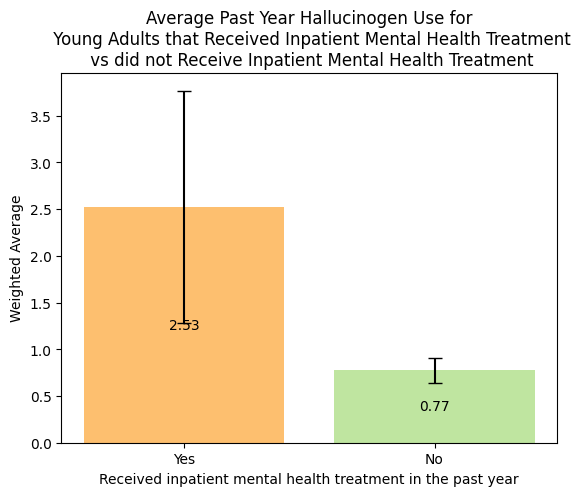

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,2.526073,0.617728,1.285329,3.766817,0.244541,1.240744,1.240744
1,PopParam.mean,No,0.773737,0.064987,0.643206,0.904267,0.083991,0.130531,0.130531


In [155]:
#Estimate average yearly hallucinogen use among Young Adults who received inpatient mental health treatment in the past year
#vs Young Adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2123,'IRHALLUCYFQ','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Hallucinogen Use for\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

# Checking Conditions

In this final section, we check the conditions necessary to do a weighted t-test before conducting the t-tests in RStudio.
In addition, we make sure the confidence interval estimates all calculated above are valid in addition to the estimates calculated in the taylor linearization and tabulation functions.

The conditions for taylor linearization are:
1. Correctly specified survey design-weights, strata, psus
2. Subpopulation definition-Use a domain (subpopulation) approach instead of dropping rows, which would bias the results to the sample
3. Sufficient number of PSUs/strata-degrees of freedom>=30
4. Assume PSUs to be independent draws-not random draws (multistage probabilistic stratified sample), but that is accounted for when we specify survey design
5. Smoothness of statistic - an example of a smooth statistic that works well for taylor estimation are the one we used: mean 
6. No extreme instability from weights
7. Correctly specified model form (if using taylor linearization for a model such as linear regression)

The conditions for tabulation are:
1. Correctly specified survey design-weights, strata, psus
2. Subpopulation definition-Use a domain (subpopulation) approach instead of dropping rows, which would bias the results to the sample
3. Sufficient number of PSUs/strata-degrees of freedom>=30
4. The effective sample size ((sum of weights)^2/sum of weights^2) should be large enough (>30 at least, ideally 50)
5. Outcome variable format-make sure outcome variable is coded consistently
6. Smoothness of statistic
7. Assume PSUs to be independent draws-not random draws (multistage probabilistic stratified sample), but that is accounted for when we specify survey design

The conditions for a weighted 95% confidence interval are:
1. Correctly specified survey design-weights, strata, psus
2. Subpopulation definition-Use a domain (subpopulation) approach instead of dropping rows, which would bias the results to the sample
3. Sufficient number of PSUs/strata-degrees of freedom>=30
4. Large-sample (CLT) conditions-Within each group/contrast, the effective sample size (sum of weights^2/sum of weights) should be large enough (>30 at least, ideally 50) for the sample mean to approximate normality 
5. No stratum with only 1 contributing PSU

The conditions for a weighted t-tests are:
1. Correctly specified survey design-weights, strata, psus
2. Subpopulation definition-Use a domain (subpopulation) approach instead of dropping rows, which would bias the results to the sample
3. Large sample (asymptotic) validity-The test statistic is approximately t- or normal-distributed if we have: a sufficiently large number of PSUs within strata (at least 2 PSUs within each stratum), and
not too many empty strata/PSUs in the domain.
4. Design Degrees of freedom-#Strata in our case (should be at least 30)
5. Distribution of variable-the variable we're taking the average of must be normally distributed
6. Assume PSUs to be independent draws-not random draws (multistage probabilistic stratified sample), but that is accounted for when we specify survey design









# Computing the number of unique strata in our sample, effective sample sizes, and number of PSUs within each stratum
Overall, given that we specify survey design and our subpopulation properly during our analysis in addition to other conditions we met during our code (e.g. choosing smooth estimates), the main conditions that we will need to check for are the following:
1. Large sample (asymptotic) validity-The test statistic is approximately t- or normal-distributed if we have: a sufficiently large number of PSUs within strata (at least 2 PSUs within each stratum), and
not too many empty strata/PSUs in the domain.
2. Large-sample (CLT) conditions-Within each group/contrast, the effective sample size (sum of weights^2/sum of weights) should be large enough (>30 at least, ideally 50) for the sample mean to approximate normality 
3. No stratum with only 1 contributing PSU
4. Design Degrees of freedom-#Strata in our case (should be at least 30)



In [156]:
#Filter to domain
df_sub = nsduh_2123.loc[nsduh_2123["CATAGE"] == 2, :]
#Count distinct PSUs by stratum
psu_by_stratum = df_sub.groupby("VESTR_C")["VEREP"].nunique().reset_index()
psu_by_stratum.columns = ["Stratum", "n_PSUs"]
print(psu_by_stratum)
#Count total strata in the domain
total_psus = df_sub["VESTR_C"].nunique()
print("Total distinct PSUs in domain:", total_psus)
#Count stratum with only 1 PSU
n_single_psu = (psu_by_stratum["n_PSUs"] == 1).sum()
print("Strata with only 1 PSU in domain:", n_single_psu)
#Compute ESS
ESS=sum(df_sub['ANALWT2_C3'])**2/sum(df_sub['ANALWT2_C3']**2)
print(ESS)

    Stratum  n_PSUs
0     40001       2
1     40002       2
2     40003       2
3     40004       2
4     40005       2
5     40006       2
6     40007       2
7     40008       2
8     40009       2
9     40010       2
10    40011       2
11    40012       2
12    40013       2
13    40014       2
14    40015       2
15    40016       2
16    40017       2
17    40018       2
18    40019       2
19    40020       2
20    40021       2
21    40022       2
22    40023       2
23    40024       2
24    40025       2
25    40026       2
26    40027       2
27    40028       2
28    40029       2
29    40030       2
30    40031       2
31    40032       2
32    40033       2
33    40034       2
34    40035       2
35    40036       2
36    40037       2
37    40038       2
38    40039       2
39    40040       2
40    40041       2
41    40042       2
42    40043       2
43    40044       2
44    40045       2
45    40046       2
46    40047       2
47    40048       2
48    40049       2
